In [20]:
from solver import Solver
from model import Net
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from experiment import get_data_loader
from lossfn import *

In [21]:
def get_train_range(dim):
    if dim == 2:
        train_range = range(1, 51, 1)
    elif dim == 3:
        train_range = range(10, 501, 10)
    elif dim == 5:
        train_range = range(50, 5001, 50)
    elif dim == 10:
        train_range = list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
    return train_range

In [22]:
def get_checkpoint_dir(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)
def get_checkpoint_dir2(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn2/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)

In [23]:
loss_fns = ['error', 'det', 'norm', 'detnorm']

In [24]:
def fn_pred_normed(pred):
    norms = torch.norm(pred.data, 2, 1)
    pred_normed = pred / norms.view(norms.shape[0], 1)
    return pred_normed

In [25]:
def plot_train_loss(dim, paths, logscale=True, labels=[], includeTest=False):
    plt.figure(figsize=(13,7))
    if len(labels) == 0:
        labels = [''] * len(paths)
    for path, label in zip(paths, labels):
        # Plot train loss
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        solver.load_checkpoint(path)
        for key in solver.hist["individual_train_losses"]:
            plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key+'_'+label)
        if includeTest:
            plt.plot(solver.hist["iterations"], solver.hist["test_loss"], label='test_'+label)
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.ylabel("train loss")
    plt.xlabel("iteration")
    plt.show()

In [34]:
def plot_test_loss(dim, train_range, keys, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False):
    plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            filepath = get_path(key, n_train)
            if os.path.exists(filepath):
                ntrains.append(n_train)
                solver.load_checkpoint(filepath)
                test_loss.append(solver.hist["test_loss"][-1])
                if includeNormed:
                    solver.fn_pred = fn_pred_normed
                    test_loss_normed.append(solver.test(test_loader, prints=False))
        plt.plot(ntrains, test_loss, label=key)
        if includeNormed:
            plt.plot(ntrains, test_loss_normed, label=str(key)+'_testnormed')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.ylabel("test loss")
    plt.xlabel("n_train")
    plt.show()

In [158]:
def plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, percentiles=True, max_iteration=float("inf")):
    plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            test_loss_n_train = []
            test_loss_normed_n_train = []
            ntrains.append(n_train)
            for stat_val in stat_range:
                model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
                solver = Solver(model)
                filepath = get_path(key, n_train, stat_val)
                if os.path.exists(filepath):
                    solver.load_checkpoint(filepath)
                    test_index = len(solver.hist["test_loss"]) - 1
                    while (solver.hist["iterations"][test_index] > max_iteration):
                        test_index -= 1
                    test_loss_n_train.append(solver.hist["test_loss"][test_index])
                    if includeNormed:
                        solver.fn_pred = fn_pred_normed
                        test_loss_normed_n_train.append(solver.test(test_loader, prints=False))
                else:
                    print('Missing filepath:')
                    print(filepath)
            test_loss.append(test_loss_n_train)
            test_loss_normed.append(test_loss_normed_n_train)
        test_loss = np.array(test_loss)
        test_loss_normed = np.array(test_loss_normed)
        if len(test_loss):
            if percentiles:
                p = plt.plot(ntrains, np.median(test_loss, axis=1), label=key)
                color = p[0].get_color()
                plt.plot(ntrains, np.percentile(test_loss, 80, axis=1), linestyle='--', color=color, linewidth=0.5)
                plt.plot(ntrains, np.percentile(test_loss, 20, axis=1), linestyle='--', color=color, linewidth=0.5)
            else: 
                plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=key)
        if includeNormed:
            plt.errorbar(ntrains, test_loss_normed.mean(axis=1), yerr=test_loss_normed.std(axis=1), capsize=5, markeredgewidth=2, label=str(key)+'_testnormed')
    plt.legend()
    plt.xlabel("number of training data points")
    plt.ylabel("Test loss")
    if logscale:
        plt.yscale('log')
    plt.show()

In [28]:
def get_angles_norms_dets(test_loader, train_loader, solver):
    all_angles = []
    all_norms = []
    all_dets = []
    for loader in [test_loader, train_loader]:
        for (points, angles, points_rotated) in loader:
            output_matrix, prediction = solver.forward(angles, points)
            all_angles += [x.item() for x in angles]
            all_norms += list(torch.norm(prediction, 2, 1).data.numpy())
            all_dets += [torch.det(mat).item() for mat in output_matrix]
    angles_norms = list(zip(all_angles, all_norms, all_dets))
    angles_norms_sorted = list(zip(*sorted(angles_norms)))
    return angles_norms_sorted

## Different loss functions for dim=2

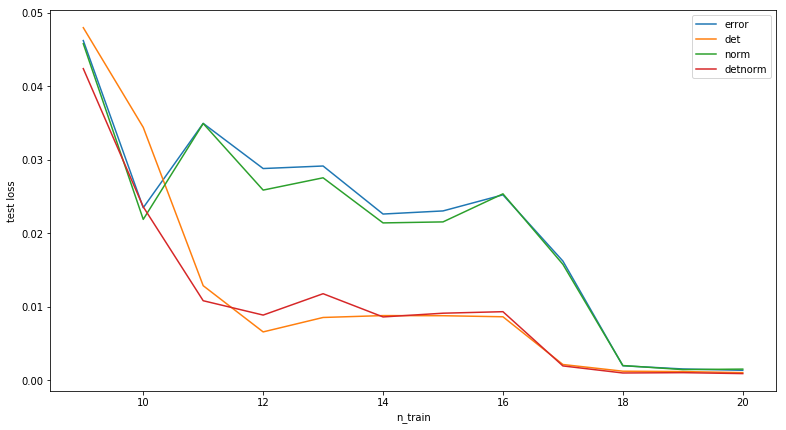

In [29]:
dim = 2
get_path = lambda key, n_train: get_checkpoint_dir(dim, n_train, key)+'final.pkl'
plot_test_loss(dim, get_train_range(dim), loss_fns, get_path, logscale=False, min_n_train=9, max_n_train=20)

## Different loss functions for dim=3

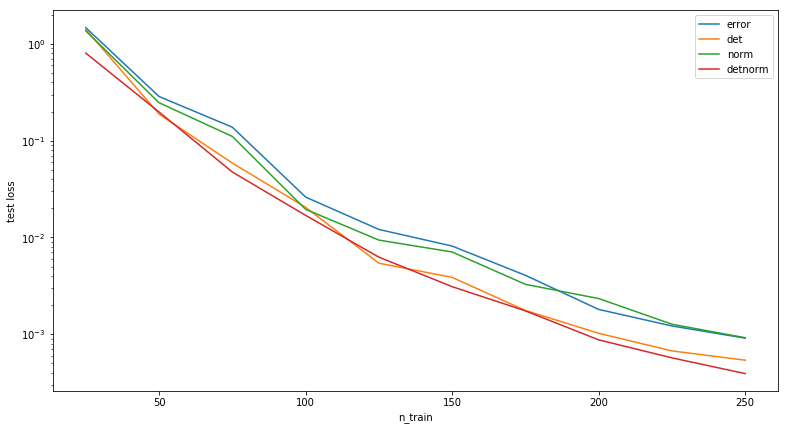

In [79]:
dim = 3
get_path = lambda key, n_train: get_checkpoint_dir2(dim, n_train, key)+'final.pkl'
plot_test_loss(dim, range(25, 251, 25), loss_fns, get_path, min_n_train=0, max_n_train=250)

## Different loss functions for dim=5

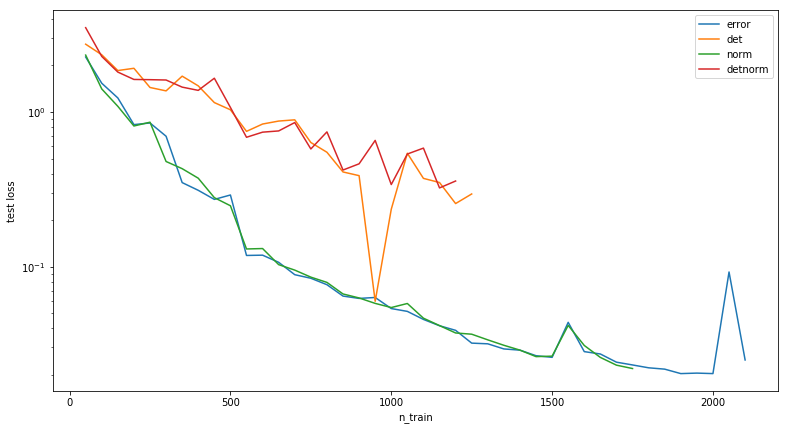

In [80]:
dim = 5
get_path = lambda key, n_train: get_checkpoint_dir(dim, n_train, key)+'final.pkl'
plot_test_loss(dim, range(50, 5001, 50), loss_fns, get_path, min_n_train=0, max_n_train=2500)

## Different loss functions for dim=10

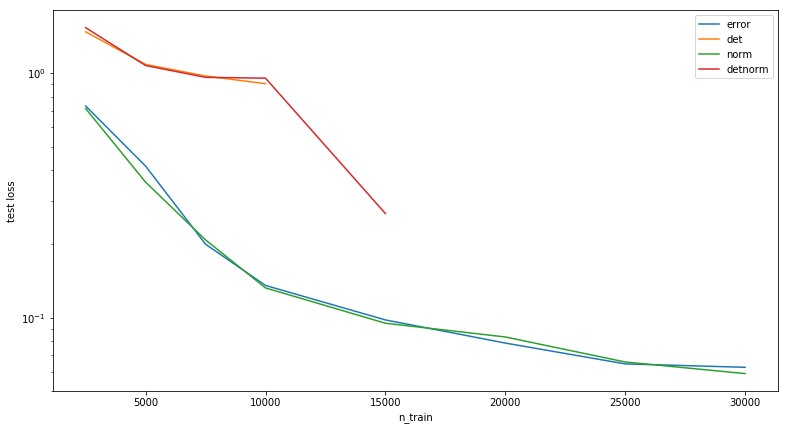

In [85]:
dim = 10
train_range = list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
get_path = lambda key, n_train: get_checkpoint_dir(dim, n_train, key)+'final.pkl'
plot_test_loss(dim, train_range, loss_fns, get_path)

## Check norm training loss

checkpoints/checkpoints-normweight/checkpoints_normweight-0.5_dim-2_ntrain-10_seed-1683/final.pkl


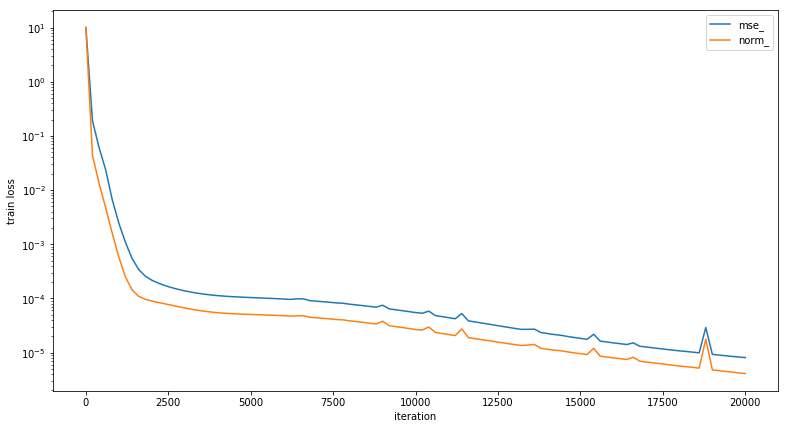

In [88]:
dim = 2
n_train = 10
norm_weight = 0.5
paths = ['checkpoints/checkpoints-normweight/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(norm_weight, dim, n_train, 1683)]
plot_train_loss(dim, paths, logscale=True)

## Determinant for different angles

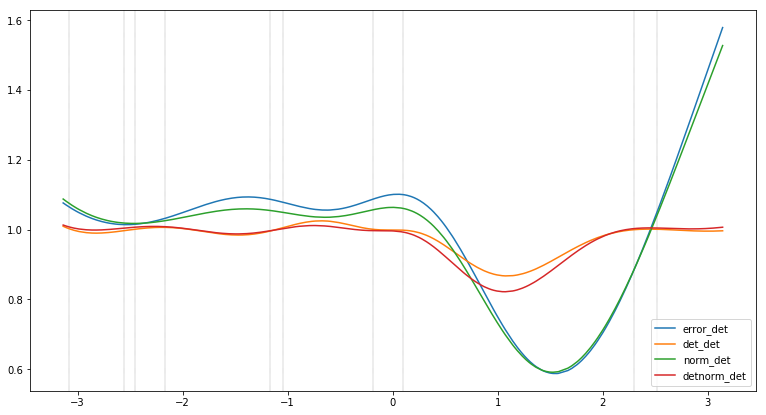

In [73]:
plt.figure(figsize=(13,7))
dim = 2
n_train = 10
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)

test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
for lossfn in loss_fns:
    dets = []
    model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
    solver = Solver(model)
    filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
    if os.path.exists(filepath):
        solver.load_checkpoint(filepath)
        angles_norms_dets = get_angles_norms_dets(test_loader, train_loader, solver)
        
        # plt.plot(angles_norms_dets[0], angles_norms_dets[1], label='norm')
        plt.plot(angles_norms_dets[0], angles_norms_dets[2], label=lossfn+'_det')

        """
        alphas = np.linspace(-math.pi, math.pi)
        matrices = solver.model(torch.FloatTensor([[a] for a in alphas]))
        dets = [torch.det(mat) for mat in matrices]
        """
        # plt.plot(alphas, dets, label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

### Determinant for dim = 5

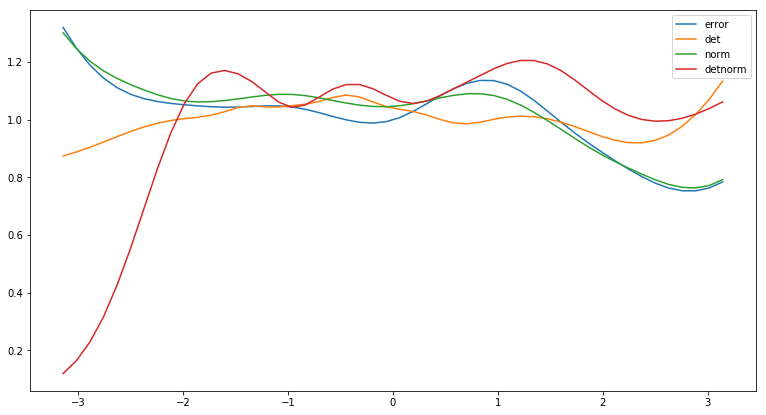

In [12]:
plt.figure(figsize=(13,7))
dim = 5
n_train = 1000
for lossfn in loss_fns:
    dets = []
    model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
    solver = Solver(model)
    filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
    if os.path.exists(filepath):
        solver.load_checkpoint(filepath)
        alphas = np.linspace(-math.pi, math.pi)
        matrices = solver.model(torch.FloatTensor([[a, 0, 0, 0] for a in alphas]))
        dets = [torch.det(mat) for mat in matrices]
        plt.plot(alphas, dets, label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

## Different det_weights

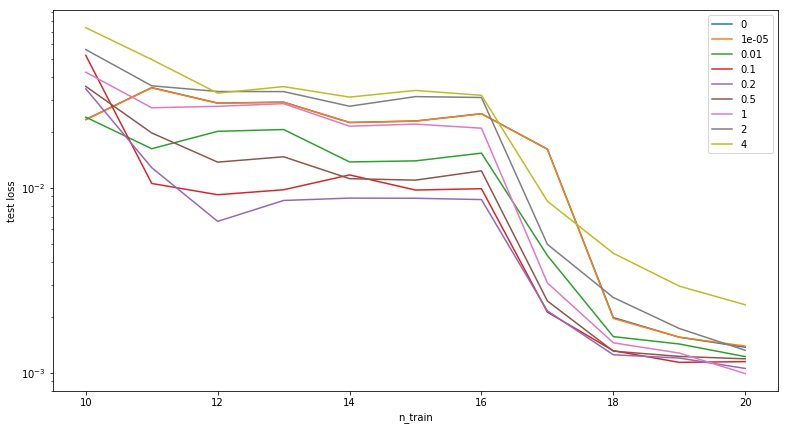

In [87]:
dim = 2
det_weights = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
get_path = lambda key, n_train: 'checkpoints/checkpoints-detweight2/checkpoints_detweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(key, dim, n_train, 1683)
plot_test_loss(dim, range(10, 21, 1), det_weights, get_path)

## Check det training loss

checkpoints/checkpoints-detweight/checkpoints_detweight-0.2_dim-2_ntrain-15_seed-1683/final.pkl


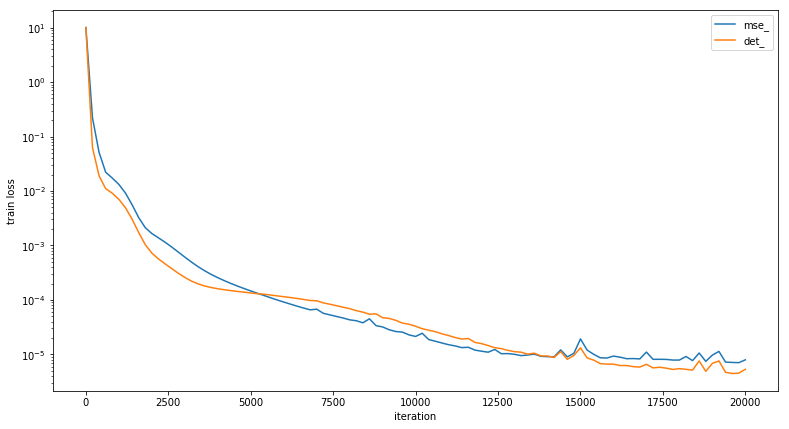

In [89]:
dim = 2
n_train = 15
det_weight = 0.2
paths = ['checkpoints/checkpoints-detweight/checkpoints_detweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(det_weight, dim, n_train, 1683)]
plot_train_loss(dim, paths, logscale=True)

## Different weight_decays

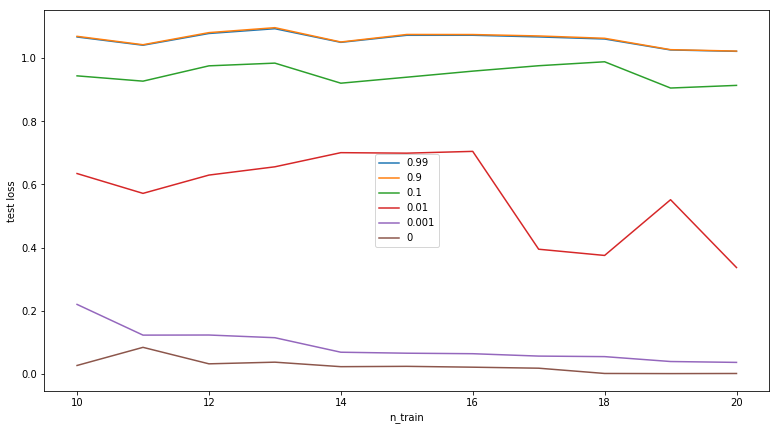

In [92]:
dim = 2
weight_decays = [0.99, 0.9, 0.1, 0.01, 0.001, 0]
def get_path(key, n_train):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'checkpoints_weight_decay_mse/'
    checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_weightdecay-{}_seed-{}'.format(dim, n_train, key,
                                                                                  1683)
    return checkpoint_dir + 'final.pkl'
plot_test_loss(dim, range(10, 21, 1), weight_decays, get_path, logscale=False)

## Statistical test loss for different loss functions

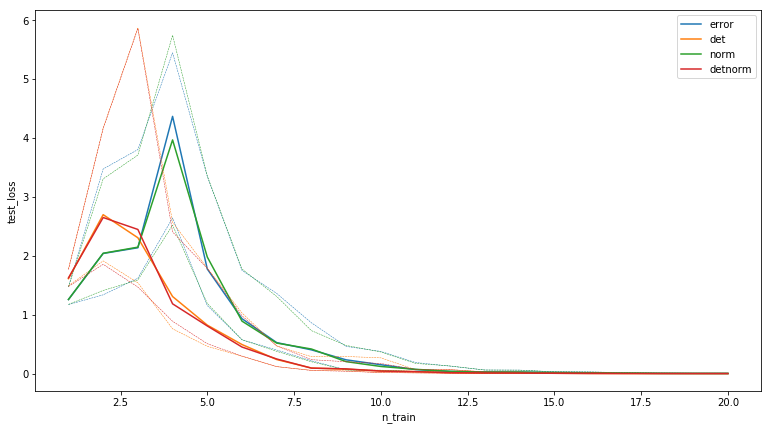

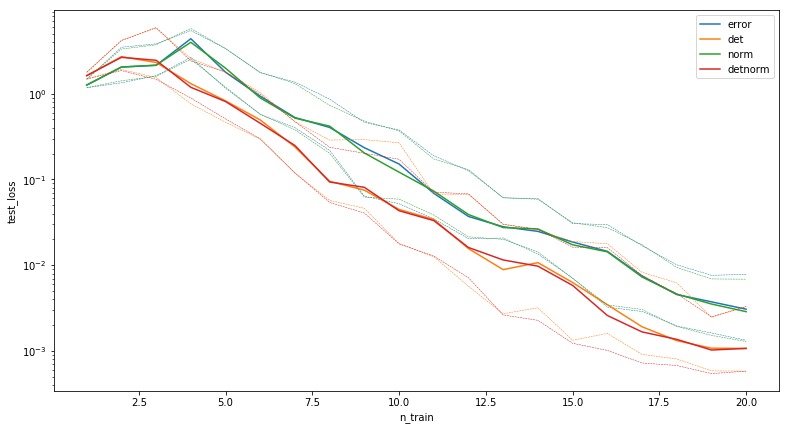

In [113]:
dim = 2
train_range = range(1, 21, 1)
keys = ['error', 'det', 'norm', 'detnorm']
stat_range = range(1683, 1683 + 20, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'checkpoints_statistical/'
    checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(
        dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, logscale=False)
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

## Different norm loss weights (Old norm loss version)

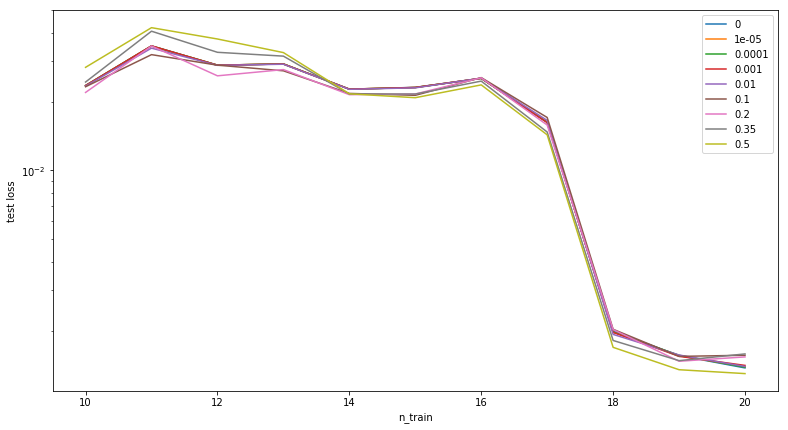

In [105]:
dim = 2
norm_weights = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.35, 0.5]
get_path = lambda key, n_train: 'checkpoints/checkpoints-normweight/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(key, dim, n_train, 1683)
plot_test_loss(dim, range(10, 21, 1), norm_weights, get_path)

## Different norm loss weights (New norm loss version)

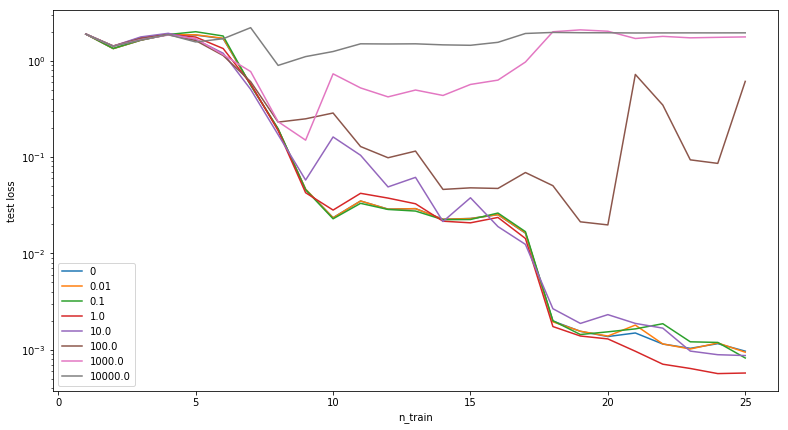

In [109]:
dim = 2
norm_weights = [0, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
get_path = lambda key, n_train: 'checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            key, dim, n_train, 1683)
plot_test_loss(dim, range(1, 26, 1), norm_weights, get_path)

### Different norm loss weights (New norm loss version) (dim=3)

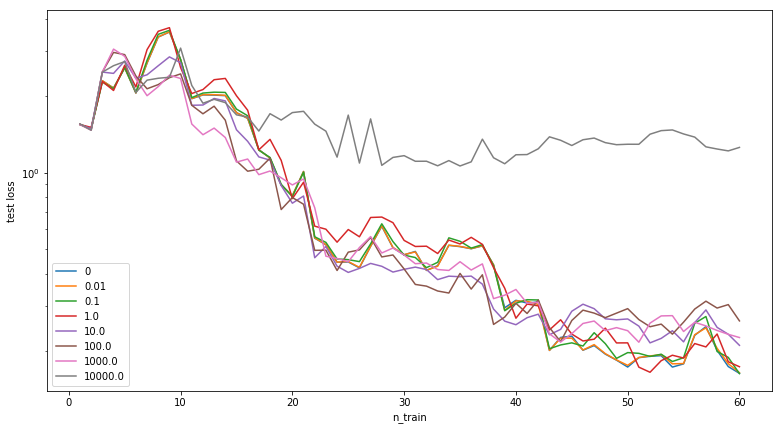

In [110]:
dim = 3
norm_weights = [0, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
get_path = lambda key, n_train: 'checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            key, dim, n_train, 1683)
plot_test_loss(dim, list(range(1, 26, 1)) + list(range(26, 61, 1)), norm_weights, get_path)

## Train loss for normweight

checkpoints/checkpoints-normweight_new/checkpoints_normweight-1.0_dim-2_ntrain-15_seed-1683/final.pkl


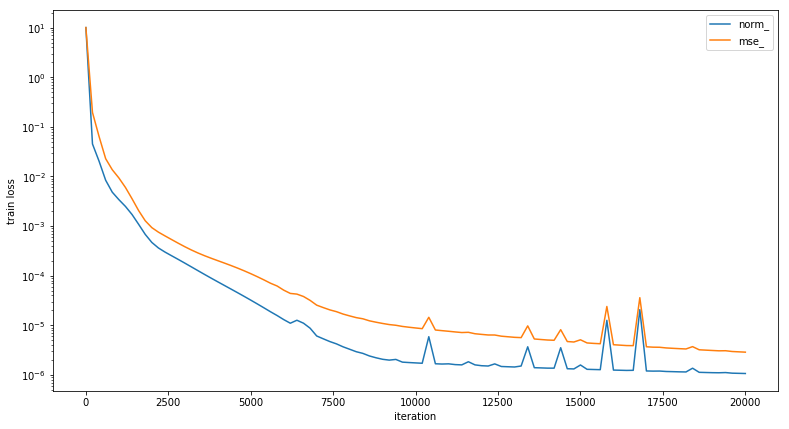

In [112]:
dim = 2
n_train = 15
norm_weight = 1e0
train_seed = 1683
paths = ['checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            norm_weight, dim, n_train, train_seed)]
plot_train_loss(dim, paths)

## Statistical norm loss weights

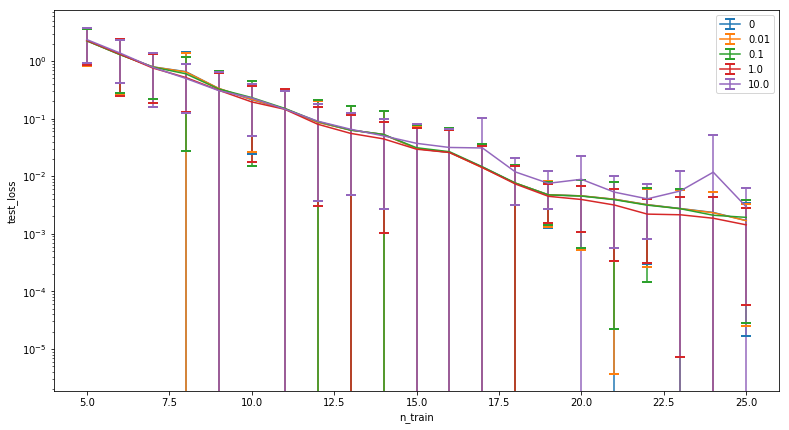

In [12]:
dim = 2
train_range = range(5, 26, 1)
norm_weights = [0, 1e-2, 1e-1, 1e0, 1e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    filepath = 'checkpoints/checkpoints-normweight_new/'
    filepath += 'checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            key, dim, n_train, stat_val)
    return filepath
plot_test_loss_statistical(dim, train_range, norm_weights, stat_range, get_path)

## Norm test loss

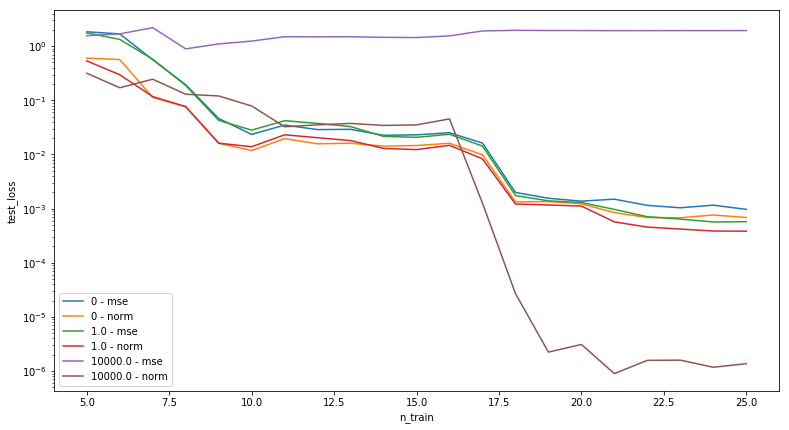

In [18]:
plt.figure(figsize=(13,7))
dim = 2
n_runs = 1 #20
train_range = range(5, 26, 1)
norm_weights = [0, 1e0, 1e4]#[0, 1e-2, 1e-1, 1e0, 1e1]
test_loader = get_data_loader(dim, 512)
for i, norm_weight in enumerate(norm_weights):
    test_loss = []
    test_norm_loss = []
    ntrains = []
    for n_train in train_range:
        test_loss_n_train = []
        test_norm_loss_n_train = []
        ntrains.append(n_train)
        for train_seed in range(1683, 1683 + n_runs, 1):
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model, loss_fn_test=[{'loss_fn': get_norm_loss(reduction='sum'), 'weight': 1, 'label': 'norm'}])
            filepath = 'checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            norm_weight, dim, n_train, train_seed)
            if os.path.exists(filepath):
                solver.load_checkpoint(filepath)
                test_loss_n_train.append(solver.hist["test_loss"][-1])
                test_norm_loss_n_train.append(solver.test(test_loader, prints=False))
            else:
                print(filepath)
        test_loss.append(test_loss_n_train)
        test_norm_loss.append(test_norm_loss_n_train)
    test_loss = np.array(test_loss)
    test_norm_loss = np.array(test_norm_loss)
    if len(test_loss):
        plt.errorbar(ntrains, test_loss.mean(axis=1), capsize=5, markeredgewidth=2, label="{} - mse".format(norm_weight))
        plt.errorbar(ntrains, test_norm_loss.mean(axis=1), capsize=5, markeredgewidth=2, label="{} - norm".format(norm_weight))
plt.legend()
plt.xlabel("n_train")
plt.ylabel("test_loss")
plt.yscale('log')
plt.show()

# Additional unsupervised data

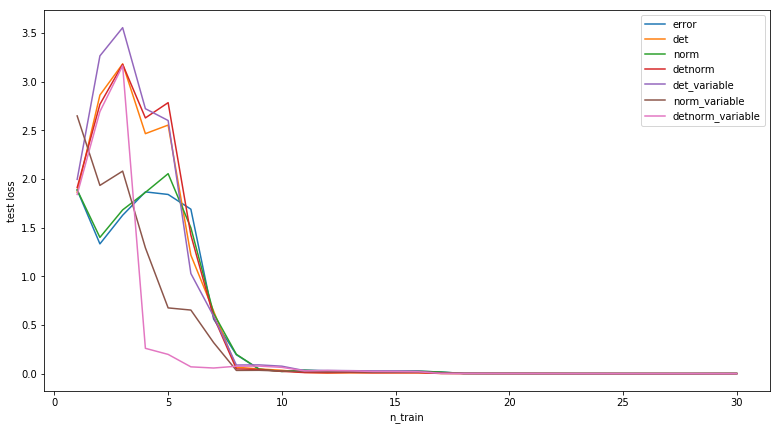

Logscale:


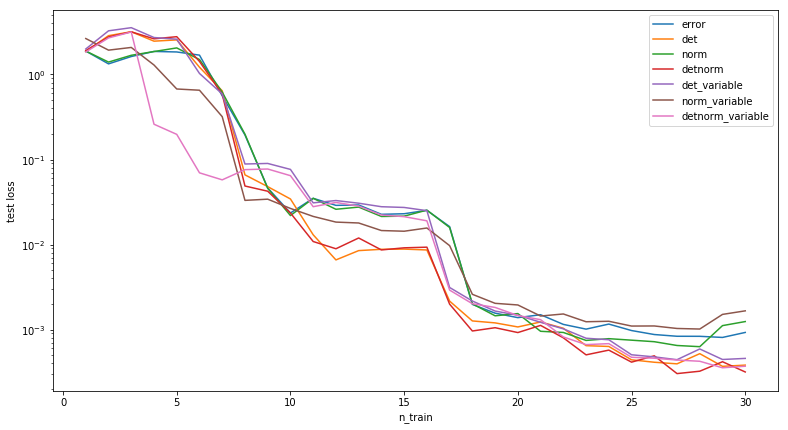

In [16]:
dim = 2
lossfnstrs = ['error', 'det', 'norm', 'detnorm', 'det_variable', 'norm_variable', 'detnorm_variable']
def get_path(key, n_train):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'checkpoints_semisupervised/'
    checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, n_train, key,
                                                                              1683)
    return checkpoint_dir + 'final.pkl'
plot_test_loss(dim, range(1, 31, 1), lossfnstrs, get_path, logscale=False)
print("Logscale:")
plot_test_loss(dim, range(1, 31, 1), lossfnstrs, get_path)

## Normed predictions

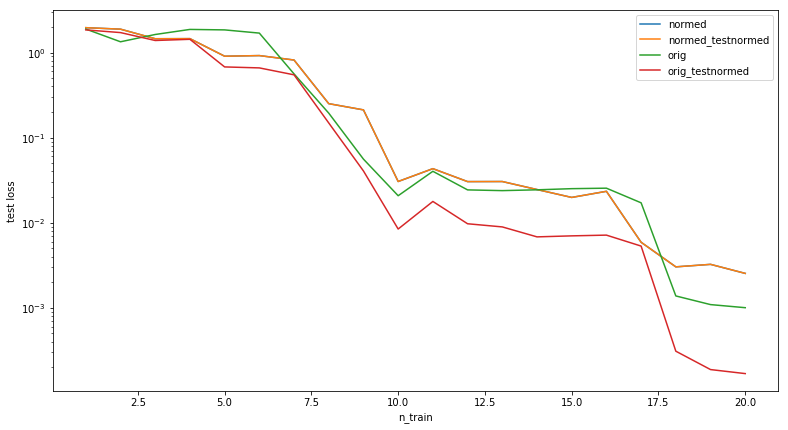

In [99]:
# After 50k iterations
dim = 2
train_seed = 1683
train_range = range(1, 21, 1) if dim == 2 else range(1, 41, 2)
keys = ["normed", "orig"]
get_path = lambda key, n_train: 'checkpoints/checkpoints-normedpred/checkpoints_normedpred-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(key, dim, n_train, train_seed)
plot_test_loss(dim, train_range, keys, get_path, includeNormed=True)

## Normed predictions statistical

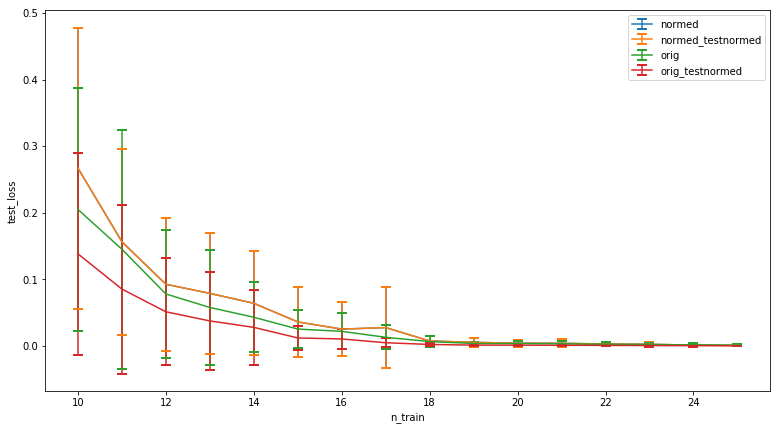

In [19]:
dim = 2
train_range = range(1, 26, 1)
keys = ["normed", "orig"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    filepath = 'checkpoints/''checkpoints-normedpred_statistical/'
    filepath += 'checkpoints_normedpred-{}_dim-{}_ntrain-{}_seed-{}/'.format(
        key, dim, n_train, stat_val)
    return filepath + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, includeNormed=True, min_n_train=10, logscale=False)

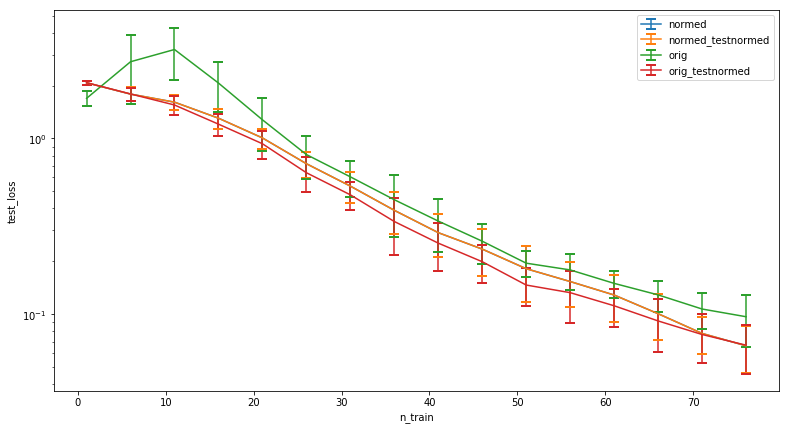

In [11]:
dim = 3
train_range = range(1, 81, 5)
keys = ["normed", "orig"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    filepath = 'checkpoints/''checkpoints-normedpred_statistical/'
    filepath += 'checkpoints_normedpred-{}_dim-{}_ntrain-{}_seed-{}/'.format(
        key, dim, n_train, stat_val)
    return filepath + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, includeNormed=True)

## Train loss for normed predictions

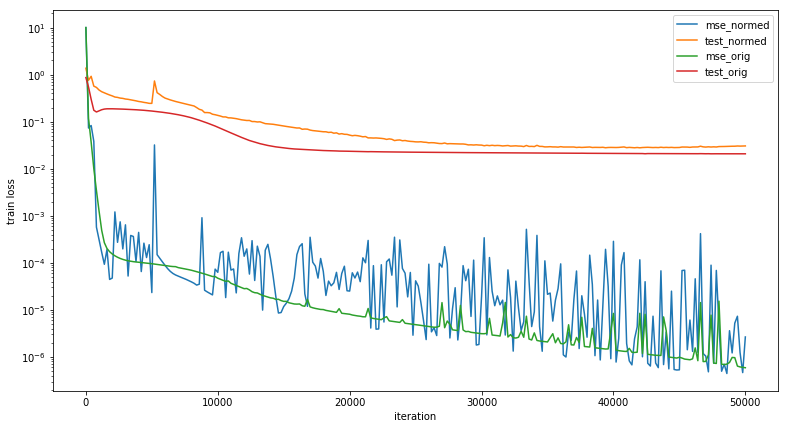

In [44]:
dim = 2
n_train = 10
train_seed = 1683
paths = []
labels = []
for fn_pred_name in ['normed', 'orig']:
    filepath = 'checkpoints/checkpoints-normedpred_statistical/checkpoints_normedpred-{}_dim-{}_ntrain-{}_seed-{}/'.format(
                    fn_pred_name, dim, n_train, train_seed)
    filepath += 'final.pkl'
    paths.append(filepath)
    labels.append(fn_pred_name)
plot_train_loss(dim, paths, labels=labels, includeTest=True)

In [12]:
dim = 2
n_train = 10
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
# solver.fn_pred = fn_pred_normed

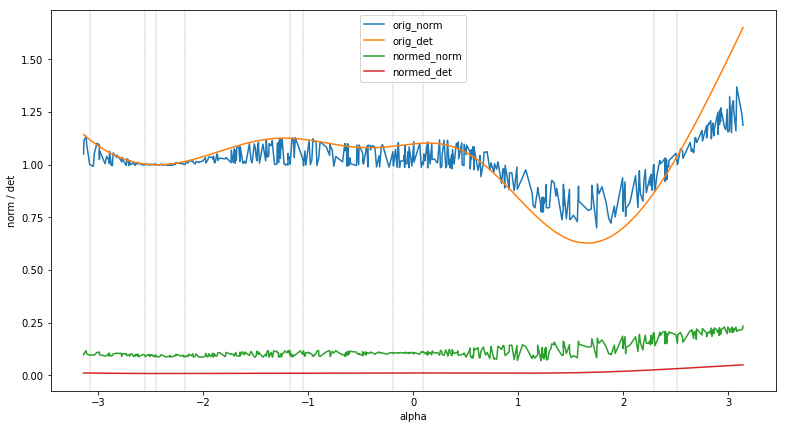

In [13]:
plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
for fn_pred_name in ['orig', 'normed']:
    path = 'checkpoints/checkpoints-normedpred_statistical/checkpoints_normedpred-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                        fn_pred_name, dim, n_train, train_seed)
    solver.load_checkpoint(path)
    angles_norms_sorted = get_angles_norms_dets(test_loader, train_loader, solver)
    plt.plot(angles_norms_sorted[0], angles_norms_sorted[1], label=fn_pred_name+'_'+'norm')
    plt.plot(angles_norms_sorted[0], angles_norms_sorted[2], label=fn_pred_name+'_'+'det')
plt.ylabel("norm / det")
plt.xlabel("alpha")
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

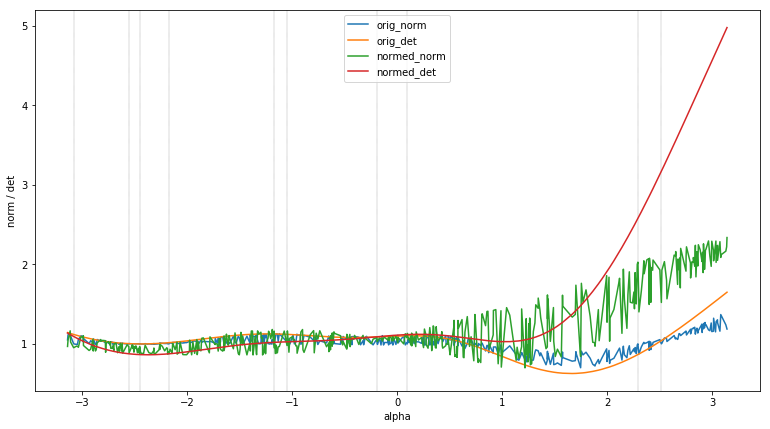

In [18]:
plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
for fn_pred_name in ['orig', 'normed']:
    path = 'checkpoints/checkpoints-normedpred_statistical/checkpoints_normedpred-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                        fn_pred_name, dim, n_train, train_seed)
    solver.load_checkpoint(path)
    angles_norms_sorted = get_angles_norms_dets(test_loader, train_loader, solver)
    c = 10 if fn_pred_name == 'normed' else 1
    plt.plot(angles_norms_sorted[0], c * np.array(angles_norms_sorted[1]), label=fn_pred_name+'_'+'norm')
    plt.plot(angles_norms_sorted[0], c * c * np.array(angles_norms_sorted[2]), label=fn_pred_name+'_'+'det')
plt.ylabel("norm / det")
plt.xlabel("alpha")
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

# Find best learning rate

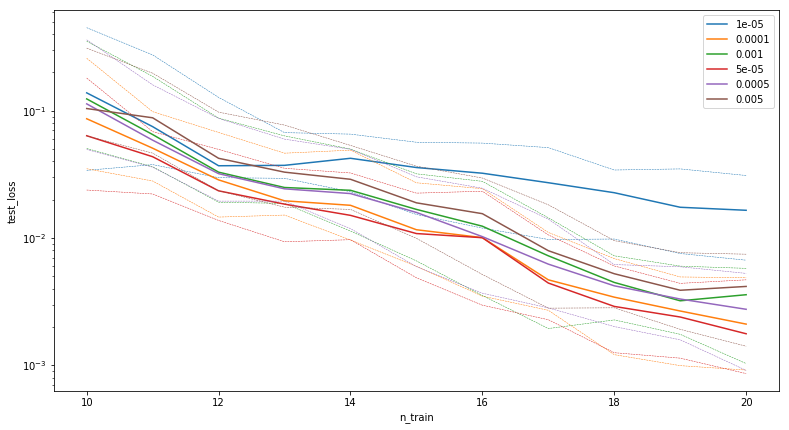

In [131]:
dim = 2
train_range = range(10, 21, 1)
keys = [1e-5, 1e-4, 1e-3] + [5*1e-5, 5*1e-4, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, max_iteration=50000)

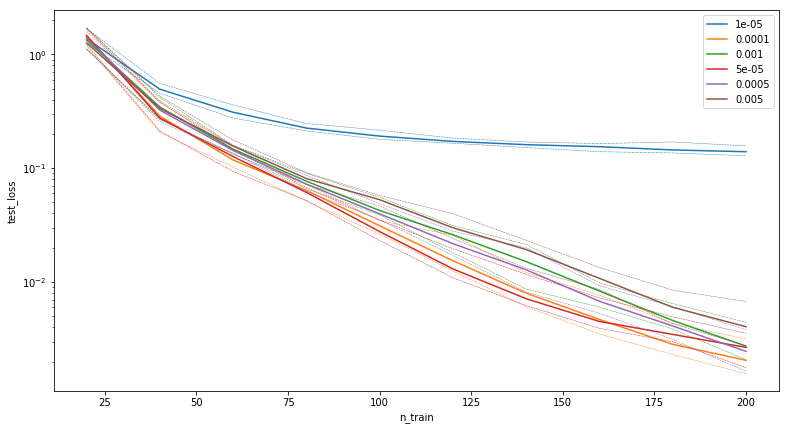

In [126]:
dim = 3
train_range = range(20, 201, 20)
keys = [1e-5, 1e-4, 1e-3] + [5*1e-5, 5*1e-4, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

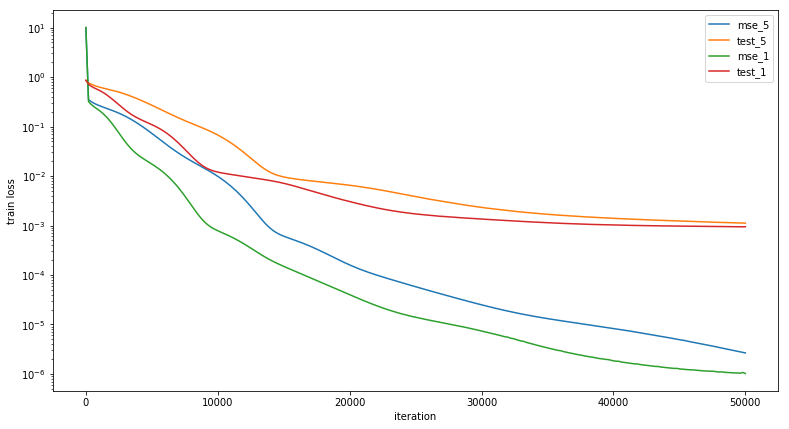

In [129]:
dim = 2
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_train_loss(dim, [get_path(5*1e-5, 20, 1683), get_path(1e-4, 20, 1683)], labels=["5", "1"], includeTest=True)

## Determinant weight

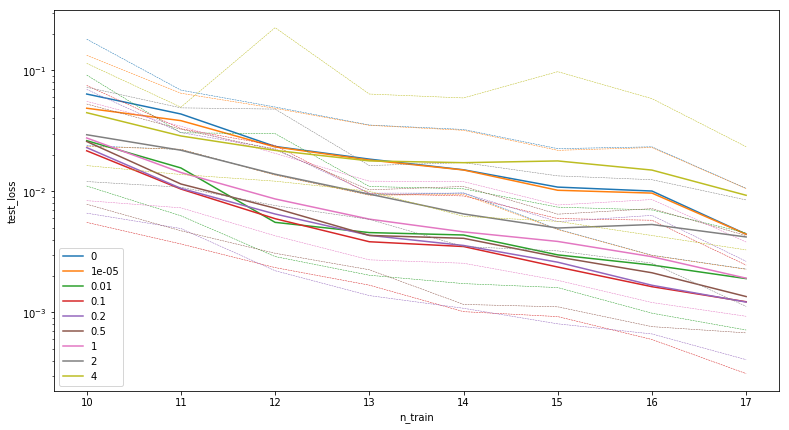

In [149]:
dim = 2
train_range = range(10, 18, 1)
keys = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

In [142]:
dim = 3
train_range = range(20, 201, 20)
keys = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight4/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

SyntaxError: 'return' outside function (<ipython-input-142-1a327efa400b>, line 1)

## Norm weights

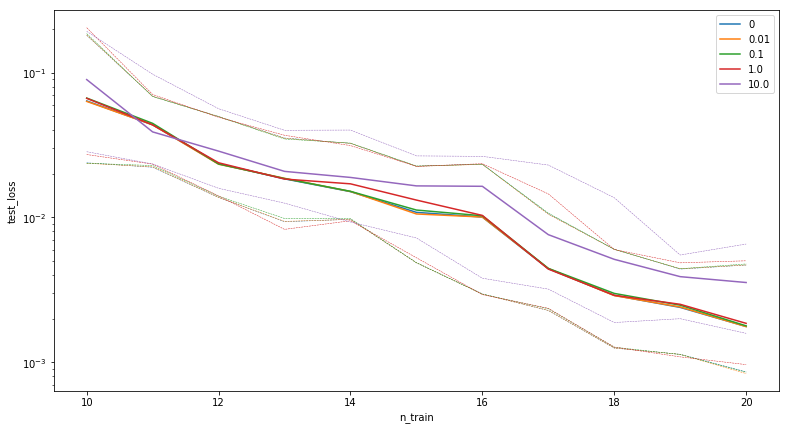

In [150]:
dim = 2
train_range = range(10, 21, 1)
keys = [0, 1e-2, 1e-1, 1e0, 1e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight2/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

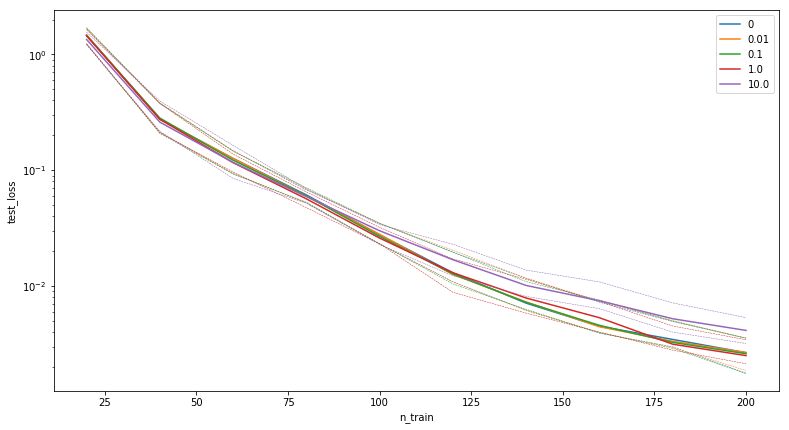

In [151]:
dim = 3
train_range = range(20, 201, 20)
keys = [0, 1e-2, 1e-1, 1e0, 1e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight2/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

## Regularization weights

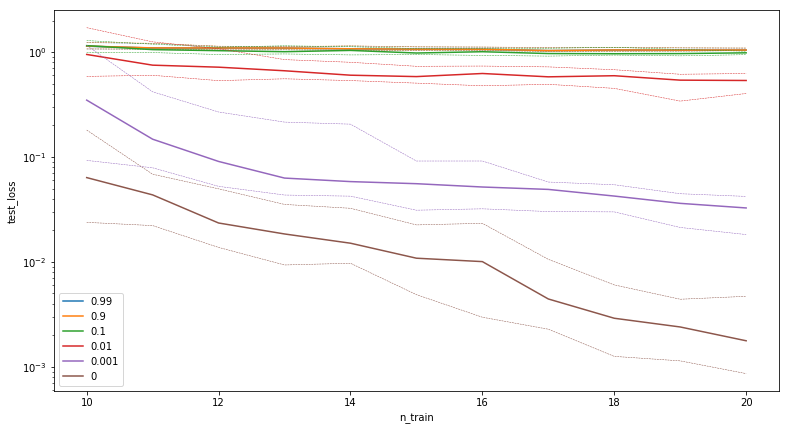

In [145]:
dim = 2
train_range = range(10, 21, 1)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

In [152]:
dim = 3
train_range = range(20, 201, 20)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

SyntaxError: 'return' outside function (<ipython-input-152-bfea883612e9>, line 1)

## Normed determinant

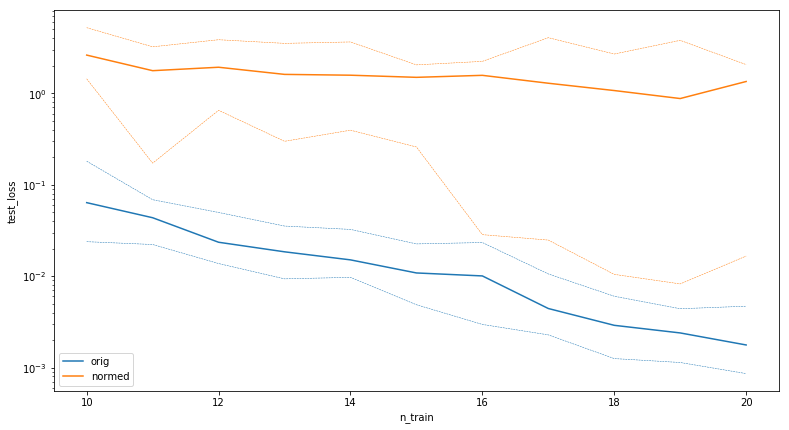

In [153]:
dim = 2
train_range = range(10, 21, 1)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

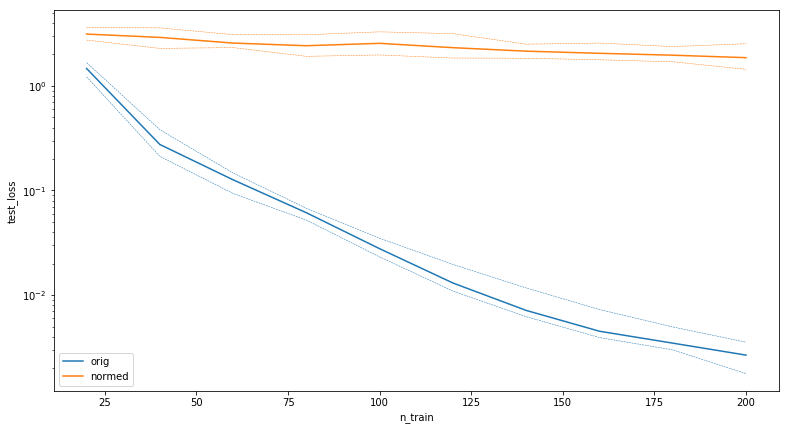

In [154]:
dim = 3
train_range = range(20, 201, 20)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

## Normed prediction

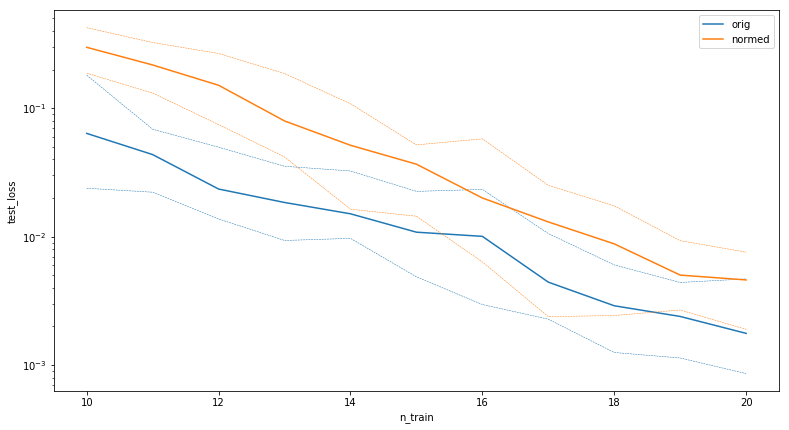

In [155]:
dim = 2
train_range = range(10, 21, 1)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

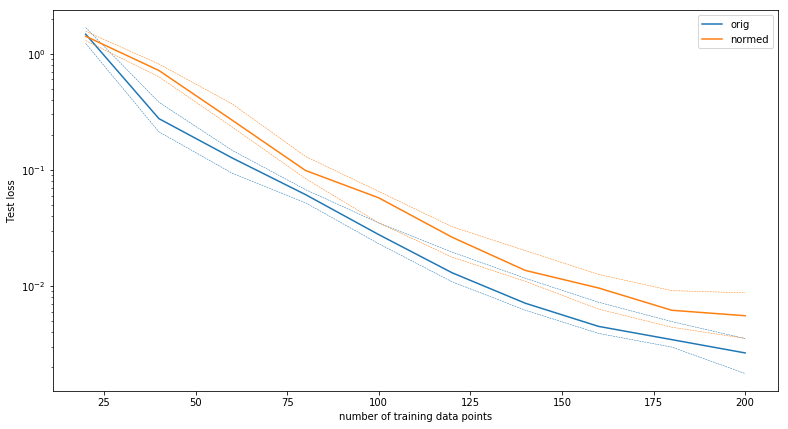

In [159]:
dim = 3
train_range = range(20, 201, 20)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)